## Discretisation

Discretisation is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range of the variable's values. Discretisation is also called **binning**, where bin is an alternative name for interval.


### Discretisation helps handle outliers and may improve value spread in skewed variables

Discretisation helps handle outliers by placing these values into the lower or higher intervals, together with the remaining inlier values of the distribution. Thus, these outlier observations no longer differ from the rest of the values at the tails of the distribution, as they are now all together in the same interval / bucket. In addition, by creating appropriate bins or intervals, discretisation can help spread the values of a skewed variable across a set of bins with equal number of observations.


### Discretisation approaches

There are several approaches to transform continuous variables into discrete ones. Discretisation methods fall into 2 categories: **supervised and unsupervised**. Unsupervised methods do not use any information, other than the variable distribution, to create the contiguous bins in which the values will be placed. Supervised methods typically use target information in order to create the bins or intervals.


####  Unsupervised discretisation methods

- Equal width discretisation
- Equal frequency discretisation
- K-means discretisation

#### Supervised discretisation methods

- Discretisation using decision trees


In this lecture, I will describe **equal width discretisation**.


## Equal width discretisation

Equal width discretisation divides the scope of possible values into N bins of the same width.The width is determined by the range of values in the variable and the number of bins we wish to use to divide the variable:

width = (max value - min value) / N

where N is the number of bins or intervals.

For example if the values of the variable vary between 0 and 100, we create 5 bins like this: width = (100-0) / 5 = 20. The bins thus are 0-20, 20-40, 40-60, 80-100. The first and final bins (0-20 and 80-100) can be expanded to accommodate outliers (that is, values under 0 or greater than 100 would be placed in those bins as well).

There is no rule of thumb to define N, that is something to determine experimentally.

## In this demo

We will learn how to perform equal width binning using the Titanic dataset with

- pandas and NumPy
- Feature-engine
- Scikit-learn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import KBinsDiscretizer


In [2]:
# load the numerical variables of the Titanic Dataset and load oinly the following columns 'age', 'fare', 'survived'

data = pd.read_csv("titanic.csv", usecols=['age', 'fare', 'survived'])

# Retrieve 1st 5 rows
data.head(1)

,survived,age,fare
0,1,29.0,211.3375


In [3]:
# separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

# Get X_train and X_test dimensions
X_train.shape, X_test.shape

((916, 2), (393, 2))

The variables Age and fare contain missing data, that should be filled by extracting a random sample of the variable.

In [4]:
def impute_na(data, variable):

    df = data.copy()

    # random sampling
    df[variable + '_random'] = df[variable]
    # first extract all the ages which are not null by dropping the null values
    # and then create the sample of random values, by using the method sample in pandas
    # the method sample mainly takes the number of rows to create as its argument.and specify the random state to 0
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)
    # the index of the sample should be the same as the dataframe
#     so that we can then fill the misiing values from the random sample  
    random_sample.index = df[df[variable].isnull()].index
#     print(df.loc[df[variable].isnull(), variable + '_random'])
#     print("========================")
    df.loc[df[variable].isnull(), variable + '_random'] = random_sample
    
#     print(random_sample)
    # finally fill the missing values with the random sample 
    return df[variable + '_random']

In [5]:
# replace NA in both train and test sets using created function on both variables 'age' and 'fare'

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

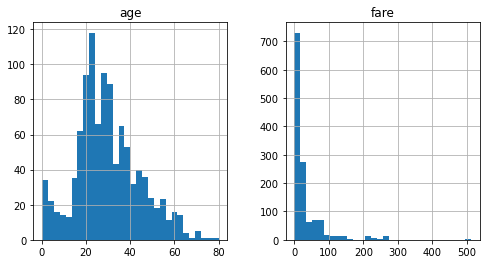

In [6]:
#the distribution of age and fare by ploting histogram of 30 bin

data[['age', 'fare']].hist(bins=30, figsize=(8,4))
plt.show()

## Equal width discretisation with pandas and NumPy

First we need to determine the intervals' edges or limits.

In [7]:
# let's capture the range of the variable age so we need to get max and min value

age_range = X_train['age'].max() - X_train['age'].min()

age_range

73.8333

In [8]:
# let's divide the range into 10 equal width bins

age_range / 10

7.383329999999999

The range or width of our intervals will be 7 years.

In [9]:
# now let's capture the lower floor and upper ceil boundaries of 'age' and make sure to store the value as an integer
# print(np.floor( X_train['age'].min()))
# print(np.ceil( X_train['age'].max()))
min_value = int(np.floor( X_train['age'].min())) 
max_value = int(np.ceil( X_train['age'].max()))

# let's round the bin width
inter_value = int(np.round(age_range / 10))

min_value, max_value, inter_value

(0, 74, 7)

In [10]:
# create a list which holds the intervals ranging from the minimum values to the max value + interval 
# having your inter_value as your interval

intervals = []
x=0
while x< max_value:
    intervals.append(x)
    x+=inter_value

intervals.append(x)
intervals

[0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77]

In [11]:
# make labels to label the different bins

labels = ['Bin_' + str(i) for i in range(1, len(intervals))]

# labels

In [12]:
# create binned age / discretise age using pandas cut method

# create one column with labels and pass the labels created in the method and 
# the bins should be your intervals list created
X_train['Age_disc_labels'] = pd.cut(x=X_train['age'],
                                    bins = intervals,
                                    labels = labels,
                                    include_lowest=True)

# and one with bin boundaries
X_train['Age_disc'] = pd.cut(x=X_train['age'],
                             bins=intervals,
                             include_lowest=True)
X_train.head(1)


,age,fare,Age_disc_labels,Age_disc
501,13.0,19.5,Bin_2,"(7.0, 14.0]"


We can see in the above output how by discretising using equal width, we placed each Age observation within one interval / bin. For example, age=13 was placed in the 7-14 interval, whereas age 30 was placed into the 28-35 interval.

When performing equal width discretisation, we guarantee that the intervals are all of the same lenght, however there won't necessarily be the same number of observations in each of the intervals. See below:

In [13]:
# count number of observation per interval , tip group both age and the discretised age together and count the observations
X_train.groupby('Age_disc')['age'].count()

Age_disc
(-0.001, 7.0]     48
(7.0, 14.0]       31
(14.0, 21.0]     155
(21.0, 28.0]     230
(28.0, 35.0]     176
(35.0, 42.0]     105
(42.0, 49.0]      75
(49.0, 56.0]      51
(56.0, 63.0]      32
(63.0, 70.0]      10
(70.0, 77.0]       3
Name: age, dtype: int64

Text(0, 0.5, 'Number of observations per bin')

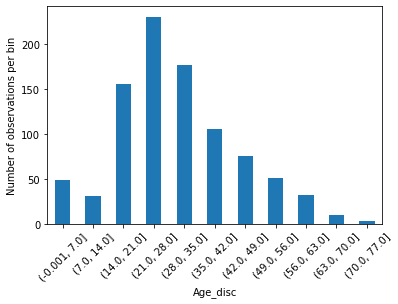

In [14]:
# plot total number of observation per interval
X_train.groupby('Age_disc')['age'].count().plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

The majority of people on the Titanic were between 14-42 years of age.

Now, we can discretise Age in the test set, using the same interval boundaries that we calculated for the train set:

In [15]:
# create one column with labels
X_test['Age_disc_labels'] = pd.cut(x=X_test['age'],
                                    bins=intervals,
                                    labels=labels,
                                    include_lowest=True)

# and one with bin boundaries
X_test['Age_disc'] = pd.cut(x=X_test['age'],
                             bins=intervals,
                             include_lowest=True)

# Retrieve 1st 10 rows
X_test.head(1)

,age,fare,Age_disc_labels,Age_disc
1139,38.0,7.8958,Bin_6,"(35.0, 42.0]"


Text(0, 0.5, 'Number of observations per bin')

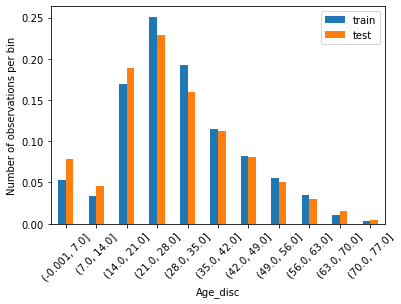

In [16]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set
# let's see that below

t1 = X_train.groupby('Age_disc')['age'].count()/ len(X_train)
t2 = X_test.groupby('Age_disc')['age'].count()/ len(X_test)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')



## Equal width discretisation with Scikit-learn

In [17]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

# Get X_train and X_test dimensions
X_train.shape, X_test.shape

((916, 2), (393, 2))

In [18]:
# replace NA in both  train and test sets
X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')


In [19]:
# Create 10 binned using Scikit learn 
disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# fit it on train dataset on both variables ‘age’ and ‘fare’
disc.fit(X_train[['age', 'fare']])

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform')

In [20]:
# Retrieve ‘age’ and ‘fare’ limits intervals using bin_edges_
disc.bin_edges_

array([array([ 0.1667 ,  7.55003, 14.93336, 22.31669, 29.70002, 37.08335,
              44.46668, 51.85001, 59.23334, 66.61667, 74.     ])         ,
       array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
              307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ])          ],
      dtype=object)

In [23]:
# Transform discretization on X_train on both variables 'age' and 'fare'
train_t = disc.transform(X_train[['age', 'fare']])

# create Dataframe of tranformed tarin dataset
train_t = pd.DataFrame(train_t, columns = ['age', 'fare'])

# retrieve 1st 5 rows
train_t.head(1)

,age,fare
0,1.0,0.0


In [24]:
## Transform discretization on X_test on both variables 'age' and 'fare'
test_t = disc.transform(X_test[['age', 'fare']])

# create Dataframe of tranformed test dataset
test_t = pd.DataFrame(test_t, columns = ['age', 'fare'])

Text(0, 0.5, 'Number of observations per bin')

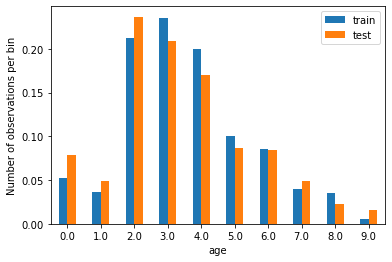

In [25]:
# Plot a bar graph for X_train and X_test on variable on variable ‘age’ percentage per interval
t1 = train_t.groupby('age')['age'].count()/ len(train_t)
t2 = test_t.groupby('age')['age'].count()/ len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

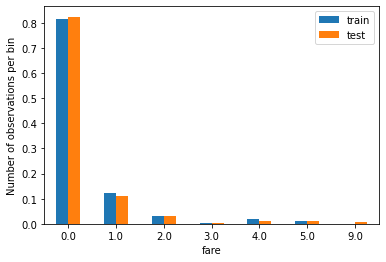

In [26]:
# Plot a bar graph for discretized X_train and X_test on variable ‘fare’ percentage per interval
# what happens when gorupping col with itself
t1 = train_t.groupby('fare')['fare'].count()/ len(train_t) 
t2 = test_t.groupby('fare')['fare'].count()/ len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

In [67]:
print("AbdelMaksoud")

AbdelMaksoud
